# Exercise Chapter 8 
Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

In [1]:
import warnings
import os
os.environ['OUTDATED_IGNORE'] = '1'
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

In [2]:
import mistat
import networkx as nx
from pgmpy.estimators import HillClimbSearch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exercise 1

In [3]:
from skfda import FDataGrid
from skfda.representation.interpolation import SplineInterpolation

dissolution = mistat.load_data('DISSOLUTION.csv')

# convert the data to FDataGrid
data = []
labels = []
names = []
for label, group in dissolution.groupby('Label'):
  data.append(group['Data'].values)
  labels.append('Reference' if label.endswith('R') else 'Test')
  names.append(label)
labels = np.array(labels)
grid_points = np.array(sorted(dissolution['Time'].unique()))
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'])

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [4]:
from skfda.preprocessing.registration import ShiftRegistration
shift_registration = ShiftRegistration()

fd_registered = {}
for order in (1, 2, 3):
    fd.interpolation = SplineInterpolation(interpolation_order=order)
    fd_registered[order] = shift_registration.fit_transform(fd)

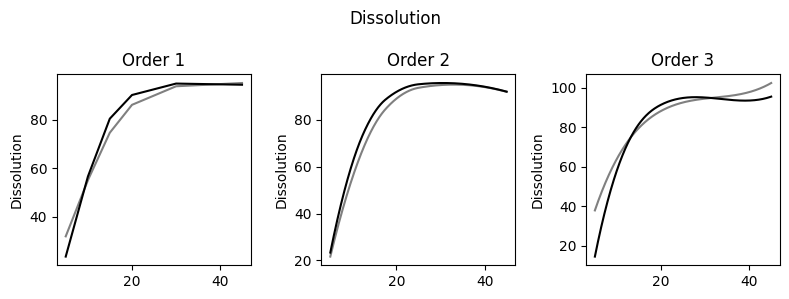

In [5]:
from skfda.exploratory import stats

group_colors = {'Reference': 'grey', 'Test': 'black'}

fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
for ax, order in zip(axes, (1, 2, 3)):
    mean_ref = stats.mean(fd_registered[order][labels=='Reference'])
    mean_test = stats.mean(fd_registered[order][labels=='Test'])
    means = mean_ref.concatenate(mean_test)
    means.plot(axes=[ax], group=['Reference', 'Test'], group_colors=group_colors)
    ax.set_title(f'Order {order}')
plt.tight_layout()

# Exercise 2

In [6]:
import skfda
from skfda import FDataGrid

pinchraw = skfda.datasets.fetch_cran('pinchraw', 'fda')['pinchraw']
pinchtime = skfda.datasets.fetch_cran('pinch', 'fda')['pinchtime']

fd = FDataGrid(pinchraw.transpose(), pinchtime)

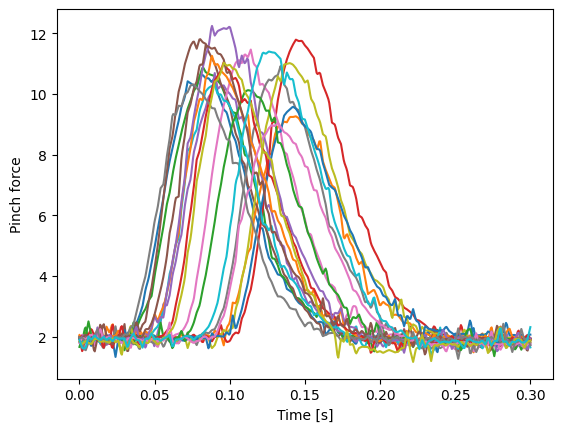

In [7]:
fig = fd.plot()
ax = fig.axes[0]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Pinch force')
plt.show()

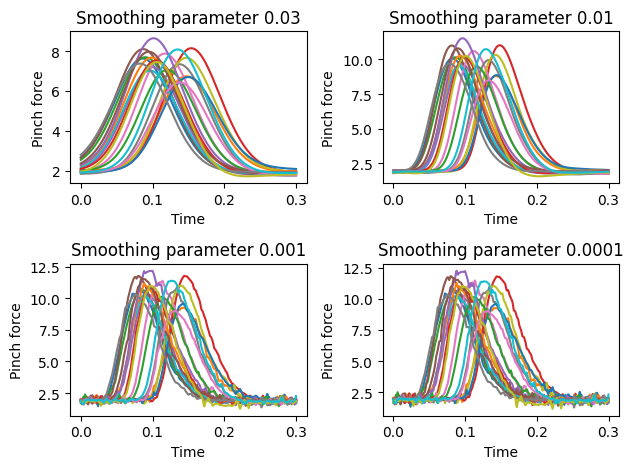

In [8]:
import itertools
from skfda.preprocessing.smoothing.kernel_smoothers import NadarayaWatsonSmoother

def plotSmoothData(fd, smoothing_parameter, ax):
    smoother = NadarayaWatsonSmoother(smoothing_parameter=smoothing_parameter)
    fd_smooth = smoother.fit_transform(fd)
    _ = fd_smooth.plot(axes=[ax])
    ax.set_title(f'Smoothing parameter {smoothing_parameter}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Pinch force')

fig, axes = plt.subplots(ncols=2, nrows=2)
axes = list(itertools.chain(*axes))  # flatten list of lists
for i, sp in enumerate([0.03, 0.01, 0.001, 0.0001]):
    plotSmoothData(fd, sp, axes[i])
plt.tight_layout()

In [9]:
smoother = NadarayaWatsonSmoother(smoothing_parameter=0.005)
fd_smooth = smoother.fit_transform(fd)

In [10]:
max_idx = fd_smooth.data_matrix.argmax(axis=1)
landmarks = [pinchtime[idx] for idx in max_idx]

In [11]:
from skfda.preprocessing.registration import landmark_shift
fd_landmark = landmark_shift(fd_smooth, landmarks)

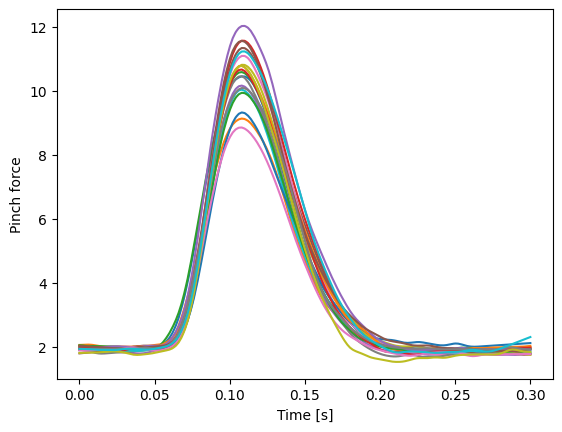

In [12]:
fig = fd_landmark.plot()
ax = fig.axes[0]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Pinch force')
plt.show()

# Exercise 3

In [13]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [14]:
import skfda

moisturespectrum = skfda.datasets.fetch_cran('Moisturespectrum', 'fds')
moisturevalues = skfda.datasets.fetch_cran('Moisturevalues', 'fds')

frequencies = moisturespectrum['Moisturespectrum']['x']
spectra = moisturespectrum['Moisturespectrum']['y']
moisture = moisturevalues['Moisturevalues']

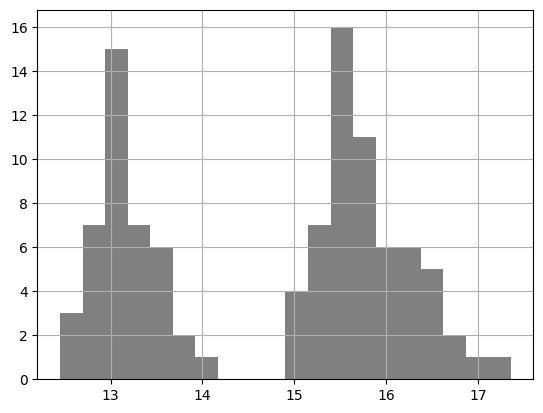

In [15]:
_ = pd.Series(moisture).hist(bins=20, color='grey', label='Moisture content')

In [16]:
moisture_class = ['high' if m > 14.5 else 'low' for m in moisture]

In [17]:
intensities = spectra.transpose()
fd = skfda.FDataGrid(intensities, frequencies)

# divide each sample spectrum by it's mean intensities
intensities_normalized = (intensities - intensities.mean(dim='dim_0')) / intensities.std(dim='dim_0')
fd_normalized = skfda.FDataGrid(intensities_normalized, frequencies)

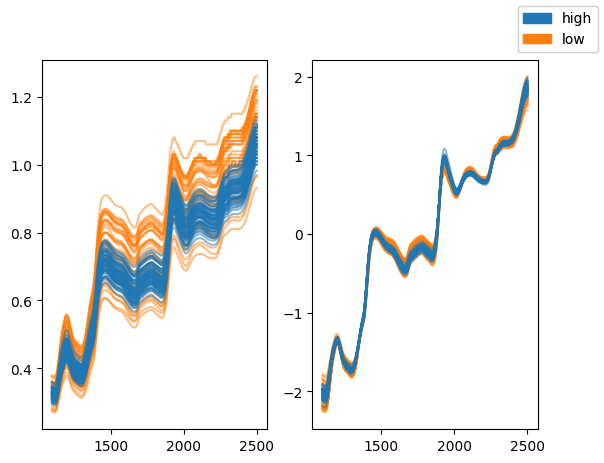

In [18]:
fig, axes = plt.subplots(ncols=2)
_ = fd.plot(axes=axes[0], alpha=0.5,
            # color lines by moisture class
            group=moisture_class, group_names={'high': 'high', 'low': 'low'})
_ = fd_normalized.plot(axes=axes[1], alpha=0.5,
            group=moisture_class, group_names={'high': 'high', 'low': 'low'})

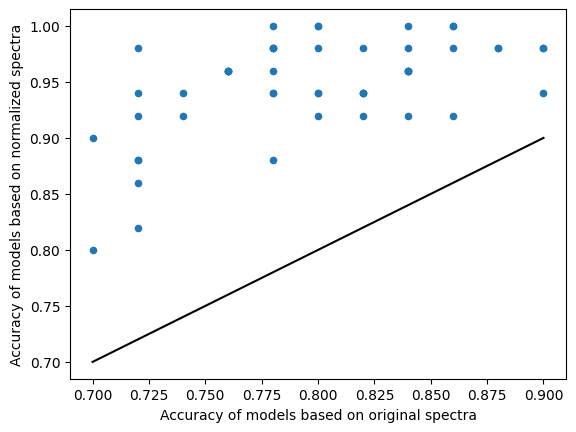

original      0.7976
normalized    0.9468
dtype: float64

In [19]:
from skfda.ml.classification import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

accuracies = []
for rs in range(50):
    X_train, X_test, y_train, y_test = train_test_split(fd,
        moisture_class, random_state=rs, test_size=0.5)
    knn_original = KNeighborsClassifier()
    knn_original.fit(X_train, y_train)
    acc_original = accuracy_score(y_test, knn_original.predict(X_test))

    X_train, X_test, y_train, y_test = train_test_split(fd_normalized,
        moisture_class, random_state=rs, test_size=0.5)
    knn_normalized = KNeighborsClassifier()
    knn_normalized.fit(X_train, y_train)
    acc_normalized = accuracy_score(y_test, knn_normalized.predict(X_test))
    accuracies.append({
        'original': acc_original,
        'normalized': acc_normalized,
    })
accuracies = pd.DataFrame(accuracies)
ax  = accuracies.plot.scatter(x='original', y='normalized')
_ = ax.plot([0.7, 0.9], [0.7, 0.9], color='black')
ax.set_xlabel('Accuracy of models based on original spectra')
ax.set_ylabel('Accuracy of models based on normalized spectra')
plt.show()

# mean of accuracies
mean_accuracy = accuracies.mean()
mean_accuracy

# Exercise 4

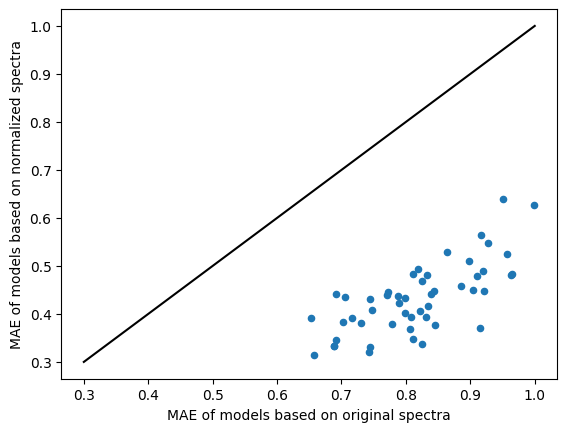

original      0.817016
normalized    0.433026
dtype: float64

In [20]:
from skfda.ml.regression import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

mae = []
for rs in range(50):
    X_train, X_test, y_train, y_test = train_test_split(fd,
        moisture, random_state=rs, test_size=0.5)
    knn_original = KNeighborsRegressor()
    knn_original.fit(X_train, y_train)
    mae_original = mean_absolute_error(y_test, knn_original.predict(X_test))

    X_train, X_test, y_train, y_test = train_test_split(fd_normalized,
        moisture, random_state=rs, test_size=0.5)
    knn_normalized = KNeighborsRegressor()
    knn_normalized.fit(X_train, y_train)
    mae_normalized = mean_absolute_error(y_test, knn_normalized.predict(X_test))
    mae.append({
        'original': mae_original,
        'normalized': mae_normalized,
    })
mae = pd.DataFrame(mae)
ax  = mae.plot.scatter(x='original', y='normalized')
ax.plot([0.3, 1.0], [0.3, 1.0], color='black')
ax.set_xlabel('MAE of models based on original spectra')
ax.set_ylabel('MAE of models based on normalized spectra')
plt.show()

# mean of MAE
mean_mae = mae.mean()
mean_mae

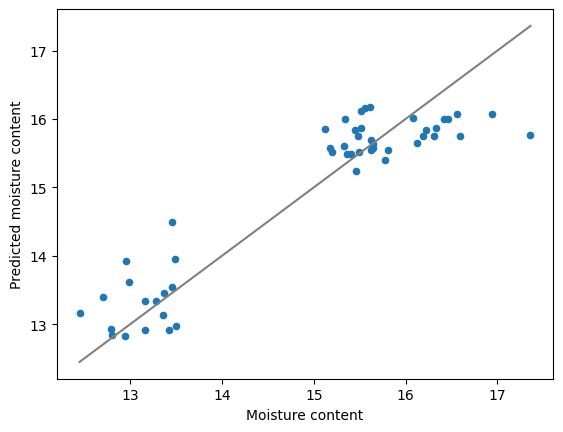

In [21]:
y_pred = knn_normalized.predict(X_test)
predictions = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
minmax = [min(*y_test, *y_pred), max(*y_test, *y_pred)]

ax = predictions.plot.scatter(x='actual', y='predicted')
ax.set_xlabel('Moisture content')
ax.set_ylabel('Predicted moisture content')
ax.plot(minmax, minmax, color='grey')
plt.show()

# Exercise 5

In [22]:
from skfda.preprocessing.dim_reduction.projection import FPCA

fpca_original = FPCA(n_components=2)
_ = fpca_original.fit(fd)

fpca_normalized = FPCA(n_components=2)
_ = fpca_normalized.fit(fd_normalized)

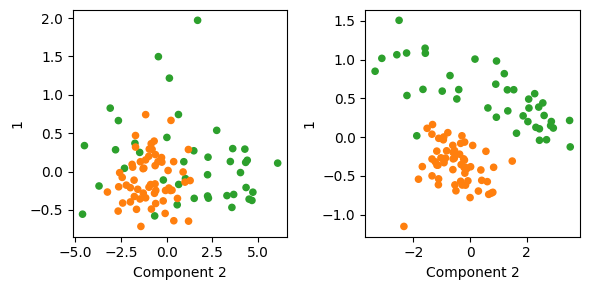

In [23]:
def plotFPCA(fpca, fd, ax):
  fpca_df = pd.DataFrame(fpca.transform(fd))
  fpca_df.plot.scatter(x=0, y=1,
      c=['C1' if mc == 'high' else 'C2' for mc in moisture_class], ax=ax)
  ax.set_xlabel('Component 1')
  ax.set_xlabel('Component 2')

fig, axes = plt.subplots(ncols=2, figsize=[6, 3])
plotFPCA(fpca_original, fd, axes[0])
plotFPCA(fpca_normalized, fd_normalized, axes[1])
plt.tight_layout()

# Exercise 6

In [24]:
from mistat.nlp import globalWarmingBlogs
blogs = globalWarmingBlogs()

In [25]:
paragraphs = []
labels = []
for blog, text in blogs.items():
  for paragraph in text.split('\n'):
    paragraph = paragraph.strip()
    if not paragraph: # ignore empty paragraphs
      continue
    paragraphs.append(paragraph)
    labels.append(blog)

In [26]:
import re
from sklearn.feature_extraction.text import CountVectorizer

def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    text = '\n'.join(line for line in text.split('\n')
                     if not line.startswith('ntsb'))
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(paragraphs)

print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (123, 1025)
total number of terms 2946


In [27]:
termCounts = np.array(counts.sum(axis=0)).flatten()
topCounts = termCounts.argsort()
terms = vectorizer.get_feature_names_out()
for n in reversed(topCounts[-10:]):
  print(f'{terms[n]:14s}  {termCounts[n]:3d}')

global           63
climate          59
warming          57
change           55
ice              35
sea              34
earth            33
ocean            29
temperatures     28
heat             25


In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [29]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(5)
norm_tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(norm_tfidf)

In [30]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [31]:
df

Topic 1  Loading 1    Topic 2  Loading 2     Topic 3  Loading 3  \
0       change   0.238417        ice   0.390362         sea   0.245752   
1      climate   0.237759        sea   0.344543       earth   0.237649   
2       global   0.233910     sheets   0.273171      energy   0.209013   
3          sea   0.219153  shrinking   0.194541       light   0.205259   
4      warming   0.210468      level   0.168988       gases   0.190392   
5          ice   0.198360     arctic   0.149491         ice   0.184441   
6  temperature   0.175102      ocean   0.127373    infrared   0.166974   
7        ocean   0.164641  declining   0.101232  greenhouse   0.161314   
8        earth   0.156206     levels   0.079976       level   0.146932   
9      extreme   0.149420   glaciers   0.073547      arctic   0.119420   

         Topic 4  Loading 4       Topic 5  Loading 5  
0        extreme   0.541783          snow   0.389494  
1         events   0.312303         cover   0.233596  
2           heat   0.232755           sea   0.162346  
3  precipitation   0.203763    hurricanes   0.132116  
4          light   0.128979         level   0.128293  
5          earth   0.122450       climate   0.118460  
6         energy   0.121819  temperatures   0.118068  
7          gases   0.115014   temperature   0.109298  
8       infrared   0.105986     decreased   0.106658  
9     greenhouse   0.105070          rise   0.100558

In [32]:
svd = TruncatedSVD(10)
norm_tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(norm_tfidf)

In [33]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [34]:
df

Topic 1  Loading 1    Topic 2  Loading 2     Topic 3  Loading 3  \
0       change   0.238490        ice   0.391264         sea   0.247785   
1      climate   0.237817        sea   0.345163       earth   0.234029   
2       global   0.234031     sheets   0.271234      energy   0.210067   
3          sea   0.219113  shrinking   0.192939       light   0.207683   
4      warming   0.210577      level   0.167905       gases   0.188448   
5          ice   0.198538     arctic   0.152350         ice   0.181658   
6  temperature   0.175060      ocean   0.128938    infrared   0.169295   
7        ocean   0.164566  declining   0.102500  greenhouse   0.156563   
8        earth   0.156193     levels   0.079045       level   0.150843   
9      extreme   0.149396   glaciers   0.072363  atmosphere   0.121715   

         Topic 4  Loading 4       Topic 5  Loading 5      Topic 6  Loading 6  \
0        extreme   0.535747          snow   0.394686          sea   0.375228   
1         events   0.308922         cover   0.234202        level   0.360142   
2           heat   0.229612           sea   0.172766         rise   0.168501   
3  precipitation   0.201331         level   0.129007      extreme   0.142637   
4          light   0.131057  temperatures   0.121623   hurricanes   0.117928   
5         energy   0.124616       climate   0.114291       events   0.113049   
6          earth   0.124399     decreased   0.110020       global   0.111682   
7          gases   0.114161    hurricanes   0.108880      impacts   0.092363   
8       infrared   0.107655   temperature   0.108092  temperature   0.092089   
9     greenhouse   0.105136      increase   0.102865      coastal   0.080255   

         Topic 7  Loading 7        Topic 8  Loading 8   Topic 9  Loading 9  \
0           snow   0.308863          ocean   0.343393  glaciers   0.361532   
1          ocean   0.296521     hurricanes   0.174912   retreat   0.233124   
2          cover   0.209618  acidification   0.159558     water   0.229019   
3  acidification   0.185627       glaciers   0.159259   glacial   0.202099   
4        extreme   0.151312          water   0.140531    months   0.155604   
5         carbon   0.136947      wildfires   0.112474    summer   0.134706   
6      pollution   0.122869         waters   0.110767    plants   0.125932   
7          point   0.115020   temperatures   0.106886     going   0.123332   
8          level   0.111283        glacial   0.095975   animals   0.113323   
9         waters   0.105585          coral   0.091589    stream   0.107685   

         Topic 10  Loading 10  
0  responsibility    0.305150  
1     authorities    0.238730  
2       pollution    0.176016  
3            heat    0.162147  
4          carbon    0.141137  
5       wildfires    0.136235  
6        personal    0.130351  
7          reduce    0.113821  
8          arctic    0.103797  
9         dioxide    0.089957

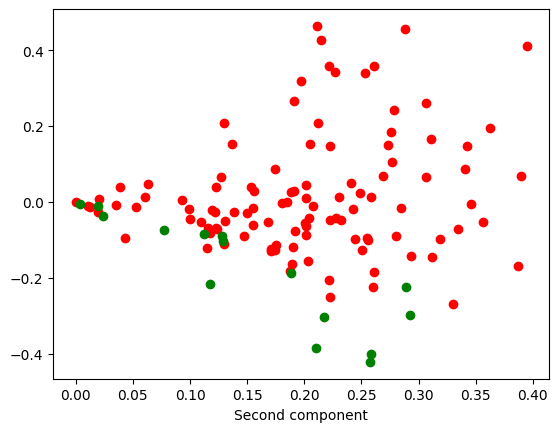

In [35]:
fig, ax = plt.subplots()
blog1 = [label == 'blog-1' for label in labels]
blog2 = [label == 'blog-2' for label in labels]
ax.plot(lsa_tfidf[blog1, 0], lsa_tfidf[blog1, 1], 'ro')
ax.plot(lsa_tfidf[blog2, 0], lsa_tfidf[blog2, 1], 'go')
ax.set_xlabel('First component')
ax.set_xlabel('Second component')
plt.show()

# Exercise 7

In [36]:
from mistat.nlp import covid19Blogs
blogs = covid19Blogs()

In [37]:
paragraphs = []
labels = []
for blog, text in blogs.items():
  for paragraph in text.split('\n'):
    paragraph = paragraph.strip()
    if not paragraph:
      continue
    paragraphs.append(paragraph)
    labels.append(blog)

def preprocessor(text):
  text = text.lower()
  text = re.sub(r'\d[\d,]*', '', text)
  text = '\n'.join(line for line in text.split('\n')
                   if not line.startswith('ntsb'))
  return text

vectorizer = CountVectorizer(preprocessor=preprocessor, stop_words='english')
counts = vectorizer.fit_transform(paragraphs)

In [38]:
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [39]:
svd = TruncatedSVD(10)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)

In [40]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [41]:
df

Topic 1  Loading 1      Topic 2  Loading 2   Topic 3  Loading 3  \
0    labour   0.286630        south   0.271191  economic   0.229255   
1     covid   0.217542       labour   0.265245   percent   0.225950   
2    impact   0.193979        north   0.215065     covid   0.189678   
3    market   0.188005  differences   0.191799       gdp   0.172073   
4     south   0.181760     americas   0.169067    impact   0.138003   
5   america   0.159973      channel   0.155954       imf   0.131283   
6  pandemic   0.151558        covid   0.132859    social   0.119520   
7   channel   0.150594       agenda   0.131577       pre   0.115100   
8  economic   0.141186         post   0.097736    growth   0.102141   
9     north   0.137054       impact   0.094960     world   0.095264   

         Topic 4  Loading 4        Topic 5  Loading 5      Topic 6  Loading 6  \
0       capacity   0.197089      household   0.145340      america   0.206105   
1      financial   0.186264          firms   0.141211  occupations   0.198370   
2          firms   0.171641  international   0.127577        latin   0.196852   
3      household   0.164821      financial   0.126116        reset   0.162589   
4  international   0.154070         global   0.125849        north   0.148039   
5          state   0.137114       capacity   0.125153  differences   0.146700   
6        markets   0.127333         labour   0.123929    represent   0.144314   
7        depends   0.127035        depends   0.117699        needs   0.136636   
8        largely   0.127035        largely   0.117699        south   0.129972   
9         access   0.123015         agenda   0.112273    argentina   0.107687   

        Topic 7  Loading 7      Topic 8  Loading 8        Topic 9  Loading 9  \
0    asymmetric   0.292830      poverty   0.200489      financial   0.187899   
1  consequences   0.277016   inequality   0.153047           self   0.166564   
2         covid   0.211519       crisis   0.147922       economic   0.164288   
3      economic   0.196590       deepen   0.136064  international   0.147880   
4    transition   0.119356        labor   0.129755         social   0.144476   
5   occupations   0.118725  differences   0.113561       employed   0.141090   
6    occupation   0.103570        adopt   0.104454      lightness   0.137512   
7        social   0.096707      working   0.104454     unbearable   0.137512   
8   differences   0.092358        large   0.104454         access   0.101213   
9     financial   0.090327    frictions   0.104454      argentina   0.093831   

       Topic 10  Loading 10  
0  preservation    0.158462  
1      recovery    0.135858  
2   differences    0.122754  
3          help    0.120395  
4        region    0.117358  
5    households    0.114543  
6   governments    0.113427  
7         north    0.108179  
8         south    0.102241  
9          cash    0.096942

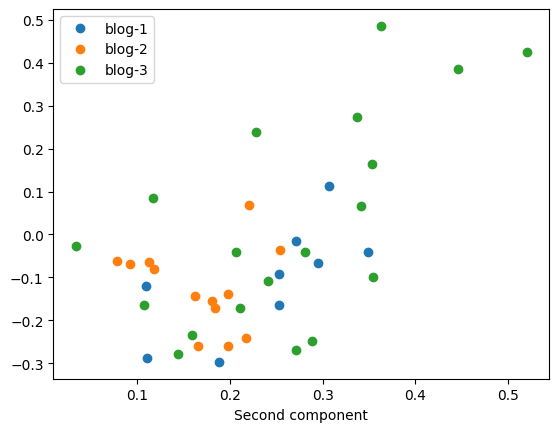

In [42]:
fig, ax = plt.subplots()
for blog in blogs:
    match = [label == blog for label in labels]
    ax.plot(lsa_tfidf[match, 0], lsa_tfidf[match, 1], 'o', label=blog)
ax.legend()
ax.set_xlabel('First component')
ax.set_xlabel('Second component')
plt.show()

# Exercise 8

In [43]:
data = mistat.load_data('LAPTOP_REVIEWS')
data['Review'] = data['Review title'] + ' ' + data['Review content']
reviews = data.dropna(subset=['User rating', 'Review title', 'Review content'])

In [44]:
import re
from sklearn.feature_extraction.text import CountVectorizer
def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(reviews['Review'])
print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (7433, 12823)
total number of terms 251566


In [45]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(20)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)
print(lsa_tfidf.shape)

(7433, 20)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

outcome = ['positive' if rating == 5 else 'negative'
           for rating in reviews['User rating']]

# split dataset into 60% training and 40% test set
Xtrain, Xtest, ytrain, ytest = train_test_split(lsa_tfidf, outcome,
                                                test_size=0.4, random_state=1)

# run logistic regression model on training
logit_reg = LogisticRegression(solver='lbfgs')
logit_reg.fit(Xtrain, ytrain)

# print confusion matrix and accuracty
accuracy = accuracy_score(ytest, logit_reg.predict(Xtest))
print(accuracy)
confusion_matrix(ytest, logit_reg.predict(Xtest))

0.7703429724277068


array([[ 851,  395],
       [ 288, 1440]])